In [168]:
import os, sys
sys.path.append('..')

import io
import torch
import numpy as np
import numpy.random as npr
import hydra
import dill

import plotly as py
import plotly.io as pio
pio.renderers.default = 'jupyterlab'
from scipy.interpolate import griddata
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import imageio

from irrep_actions.gym_util.multistep_wrapper import MultiStepWrapper
from irrep_actions.env.pusht.pusht_keypoints_env import PushTKeypointsEnv
from irrep_actions.workflow.base_workflow import BaseWorkflow
from irrep_actions.utils import mcmc

In [169]:
# CH SO2 Lmax 5
# checkpoint = '../data/outputs/2024.01.30/16.43.31_train_so2_harmonic_implicit_policy_pusht_lowdim/checkpoints/latest.ckpt'

# CH SO2 Lmax 3
#checkpoint = '../data/outputs/2024.01.30/06.16.01_train_so2_harmonic_implicit_policy_pusht_lowdim/checkpoints/epoch=0400-test_mean_score=0.975.ckpt'

# CH skip
# checkpoint = '../data/outputs/2024.01.30/19.08.21_train_so2_harmonic_implicit_policy_pusht_lowdim/checkpoints/latest.ckpt'

checkpoint = '../data/outputs/2024.02.05/16.51.30_train_so2_harmonic_implicit_policy_pusht_lowdim/checkpoints/latest.ckpt'

payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
device = torch.device('cuda:0')

In [170]:
cfg = payload['config']
cls = hydra.utils.get_class(cfg._target_)

workflow = cls(cfg)
workflow: BaseWorkflow
workflow.load_payload(payload, exclude_keys=None, include_keys=None)

policy = workflow.model
policy = policy.to(device)
policy.eval()

ImplicitPolicy(
  (normalizer): LinearNormalizer(
    (params_dict): ParameterDict(
        (obs): Object of type: ParameterDict
        (action): Object of type: ParameterDict
      (obs): ParameterDict(
          (offset): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
          (scale): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
          (input_stats): Object of type: ParameterDict
        (input_stats): ParameterDict(
            (max): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
            (mean): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
            (min): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
            (std): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
        )
      )
      (action): ParameterDict(
          (offset): Parameter containing: [torch.cuda.FloatTensor of size 2 (cuda:0)]
          (scale): Parameter containing: [torch.c

In [171]:
env = MultiStepWrapper(
    PushTKeypointsEnv(render_action=False, random_goal_pose=False),
    n_obs_steps=2,
    n_action_steps=1, 
    max_episode_steps=300)
env.seed(100018)

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


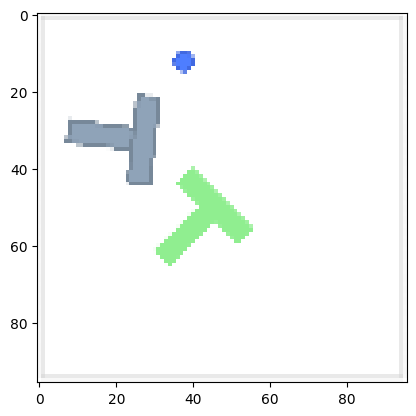

In [172]:
obs = env.reset()
d = False
B = 1
img = env.render('human')
plt.imshow(img)
plt.show()

In [199]:
def step(env, obs, policy, plot=True):
    Do = obs.shape[-1] // 2 
    obs = torch.from_numpy(obs[:, :Do].astype(np.float32).reshape(B,2,-1,2)).to(device) # 1x2x19x2
    x_obs = (obs.reshape(1,38,2)[:,:,0] - 255.0)
    y_obs = (obs.reshape(1,38,2)[:,:,1] - 255.0) * -1.0
    new_d = torch.concatenate((x_obs.unsqueeze(-1), y_obs.unsqueeze(-1)), dim=-1).view(1, -1).view(1,2,19*2)
    nobs = policy.normalizer['obs'].normalize(new_d)
    
    action_stats = policy.get_action_stats()
    action_dist = torch.distributions.Uniform(
        low=action_stats["min"], high=action_stats["max"]
    )
    actions = action_dist.sample((1, policy.pred_n_samples, 1)).to(
        dtype=nobs.dtype
    )
    num_disp = 1000
    num_rot = 360
    mag = torch.linspace(-1.0, 1.0, num_disp)
    mag = mag.view(1, -1).repeat(B, 1).view(B, -1, 1, 1).to(device)
    theta = torch.linspace(0, 2*np.pi, num_rot).to(device)
    
    with torch.no_grad():
        logits = policy.energy_model.get_energy_ball(nobs, mag).view(1, -1)
    #action_probs = torch.softmax(logits.view(1, num_disp, num_rot), dim=1)
    action_probs = torch.softmax(logits/1, dim=1).view(1, num_disp, num_rot)
    
    flat_indexes = action_probs.flatten(start_dim=-2).argmax(1)
    idx = [divmod(idx.item(), action_probs.shape[-1]) for idx in flat_indexes][0]
    actions = torch.tensor([mag[0,idx[0],0,0], theta[idx[1]]])
    max_disp = torch.max(action_probs, dim=-1)[0]
    
    img = env.render('human')
    plt.imshow(img)
    plt.show()
    
    un_mag = policy.normalizer["action"].unnormalize(torch.concat((mag.view(1,-1,1).cpu(), torch.zeros(1,num_disp,1)), dim=-1))[0,:,0]
    
    xs = (un_mag[:].view(num_disp, 1) @ torch.cos(theta.view(1,360))).view(-1).cpu().numpy()
    ys = (un_mag[:].view(num_disp, 1) @ torch.sin(theta.view(1,360))).view(-1).cpu().numpy()
    zs = action_probs[0,:].view(-1).cpu().numpy()
    #zs = logits[0,:].view(-1).cpu().numpy()
    
    if plot:
        data = go.Scatter3d(
            x=xs, 
            y=ys, 
            z=zs,
            mode='markers', 
            marker=dict(
                size=1,
                color=zs,                # set color to an array/list of desired values
                colorscale='Viridis',   # choose a colorscale
                opacity=0.8
            )
        )
        layout = go.Layout(
            autosize=False,
            width=1000,
            height=1000,
            xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
            yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
            margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
        )
        fig = go.Figure(data=[data], layout=layout)
        fig.show()
    
    mag = policy.normalizer["action"].unnormalize(actions)[0]
    theta = actions[1]
    x = mag * torch.cos(theta)
    y = mag * torch.sin(theta)
    actions = torch.concat([x.view(B,1), y.view(B,1)], dim=1).unsqueeze(1)
    
    x_act = actions[:,:,0]
    y_act = actions[:,:,1] * -1.0
    new_act = torch.concatenate((x_act, y_act), dim=-1).view(B,1,2)
    obs, r, d, _ = env.step(new_act.squeeze(0).cpu().numpy())

    return obs

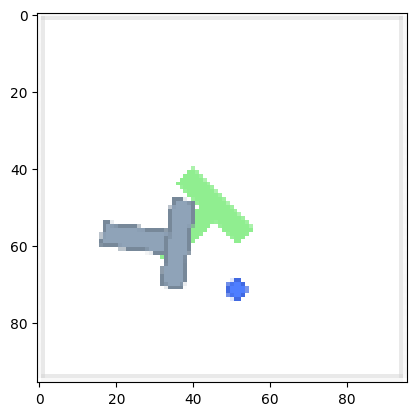

In [368]:
obs = step(env, obs, policy, plot=False)